In [21]:
#%matplotlib notebook
%matplotlib inline
from matplotlib import rc
rc('figure',figsize=(12,10))
rc('font',size=12)
rc('text',usetex=False)

from qubicpack import qubicpack as qp
import fibtools as ft
import lin_lib as ll
import plotters as p

import numpy as np
from matplotlib.pyplot import *
import matplotlib.mlab as mlab
import scipy.ndimage.filters as f
import glob
import string
import datetime as dt

There are two datasets to be anayzed:
- *linearityA* : offset is always 1V and we go from 0.5V to 2V amplitude. In this dataset the modulation does not always reach zero amplitude for the source.
- *linearityB* : Amplitude is always 2xOffset so that the modulation always goes from 0 to Amplitude 

In the following cell we read the corresponding filenames and order them, detect the offstes, amplitudes and modulation frequencies. We order the files by the amplitude of the modulation.

In [17]:
day = '2019-03-01'
data_dir = '/qubic/Data/Calib-TD/'+day+'/'
dirs = np.array(glob.glob(data_dir+'/*LinearityA*'))
dirs.sort()

#if day=='2019-02-28':
#    dirs = dirs[0:-1]

print dirs
print ''
labels = []
for d in dirs:
    bla = str.split(d,'__')
    labels.append(bla[1])
labels = np.array(labels)

modfreqs = np.zeros(len(labels))
amps = np.zeros(len(labels))
offsets = np.zeros(len(labels))
for i in xrange(len(labels)):
    bla = str.split(labels[i],'_')
    modfreqs[i] = np.float(bla[2][0:len(bla[2])-2])
    amps[i] = np.float(bla[4])
    offsets[i] = np.float(bla[6])

    
order = np.argsort(amps)
modfreqs = modfreqs[order]
amps = amps[order]
offsets = offsets[order]
labels = labels[order]
dirs = dirs[order]
print ''
print(dirs)
print ''
print labels
print(amps)
print(offsets)
print(modfreqs)

['/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500'
 '/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.38.21__LinearityA_sin_0.333Hz_amp_1.500_off_2.500'
 '/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.41.24__LinearityA_sin_0.333Hz_amp_1.750_off_2.500'
 '/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.44.29__LinearityA_sin_0.333Hz_amp_2.000_off_2.500'
 '/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.47.47__LinearityA_sin_0.333Hz_amp_2.500_off_2.500'
 '/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.50.46__LinearityA_sin_0.333Hz_amp_3.000_off_2.500'
 '/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.53.34__LinearityA_sin_0.333Hz_amp_3.500_off_2.500'
 '/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.56.25__LinearityA_sin_0.333Hz_amp_4.000_off_2.500'
 '/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.59.19__LinearityA_sin_0.333Hz_amp_4.500_off_2.500'
 '/qubic/Data/Calib-TD/2019-03-01/2019-03-01_15.02.19__LinearityA_sin_0.333Hz_amp_5.000_off_2.500']


['/qubi

And there are source data associated, that are read below. It contains time (computer-time from the rasberry pi) and amplitude of the power-meter. We read them all for this day and concatenate them. Later we'll pick the common period corresponding to each data file.

['/qubic/Data/Calib-TD/calsource/calsource_20190301T133531.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190301T133828.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190301T134131.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190301T134435.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190301T134754.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190301T135053.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190301T135340.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190301T135631.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190301T135925.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190301T140226.dat']


(0, 200)

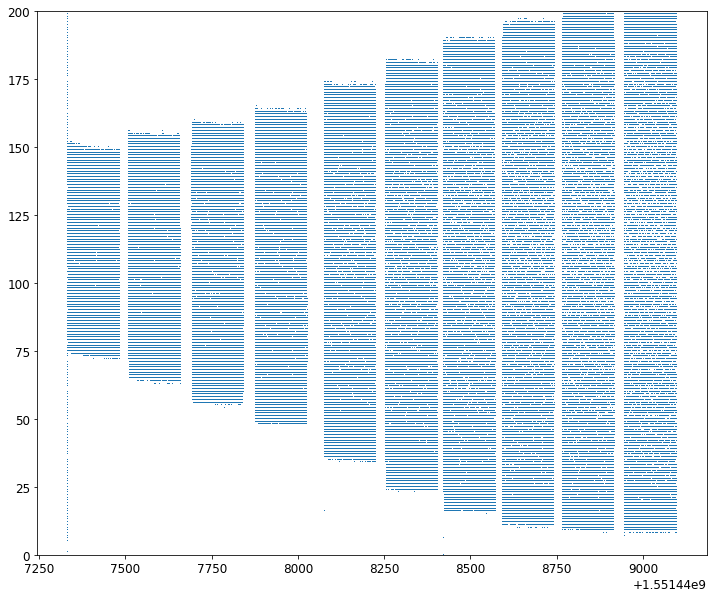

In [18]:
### The date format for calsrc has no '-' so we need to change the day to this very format.
daycalsrc = "".join(str.split(day,'-'))
fcalsrc = glob.glob('/qubic/Data/Calib-TD/calsource/*'+daycalsrc+'*')
fcalsrc.sort()
print fcalsrc

ttsrc = []
ddsrc = []
for ff in fcalsrc:
    thett, thedd = np.loadtxt(ff).T
    ttsrc.append(thett+3600)
    ddsrc.append(thedd)
    
ttsrc = np.concatenate(ttsrc)
ddsrc = np.concatenate(ddsrc)
plot(ttsrc,ddsrc,',')
ylim(0,200)

Now we read the data, then we find the common time between data and calsrc, then we put this into lists for each of the file.

In [19]:
tt = []
dd = []
mm = []
tt_src = []
dd_src = []
temperatures = []
asicnum = 1
TESnum = 96
for thedir in dirs:
    print ''
    print(thedir)
    a = qp()
    a.read_qubicstudio_dataset(thedir, asic=asicnum)
    temperatures.append(a.temperature)
    nsamples = len(a.timeline(TES=96))
    pow2 = int(np.log(nsamples)/np.log(2))
    ns = 2**pow2
    FREQ_SAMPLING = 1./a.sample_period()

    #### Old version: no PPS, data timeline is just a linspace
    t_data = a.timeline_timeaxis(axistype='index')
    t0 = a.timeline_timeaxis(axistype='pps')[0]
    t_data = t_data + t0
    #### NEW version with PPS accounted for
#     t_data = a.timeline_timeaxis(axistype='pps')
#     t0 = t_data[0]
    import datetime as dt
    print('')
    print('DAta TIME:')
    print(thedir)
    print(dt.datetime.fromtimestamp(np.min(t_data)))
    print(dt.datetime.fromtimestamp(np.max(t_data)))
    print('SRC TIME:')
    print dt.datetime.fromtimestamp(np.min(ttsrc))
    print dt.datetime.fromtimestamp(np.max(ttsrc))
    
    data = a.timeline(TES=TESnum)


#     print t_data[0:10]-t0
#     print ttsrc[0:10]-t0
#     plot(t_data-t0, data, ',')
#     plot(ttsrc-t0, ddsrc*1000)

    ### Find the region where there is source data
    oksrc = (ttsrc >= (t_data[0])) & (ttsrc <=(t_data[-1]))
    print 'Number of common points: {}'.format(oksrc.sum())
    thettsrc = ttsrc[oksrc]
    theddsrc = ddsrc[oksrc]
    
    
    ### now reduce each to matching regions
    print [np.min(t_data), np.min(thettsrc)]
    mini = np.max([np.min(t_data), np.min(thettsrc)])
    maxi = np.min([np.max(t_data), np.max(thettsrc)])
    okdata = (t_data >= mini) & (t_data <= maxi)
    oksrc = (thettsrc >= mini) & (thettsrc <= maxi)
    t_data = t_data[okdata]
    data = data[okdata]
    thettsrc = thettsrc[oksrc]
    theddsrc = theddsrc[oksrc]
        
    tt.append(t_data-t0)
    dd.append(data)
    mm.append(np.mean(data))
    tt_src.append(thettsrc-t0)
    dd_src.append(theddsrc)



/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500
Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500/Sums/science-asic1-2019.03.01.143525.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500/Sums/science-asic1-2019.03.01.143525.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500/Hks/hk-intern-2019.03.01.143529.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500/Hks/hk-intern-2019.03.01.143529.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.35.2

mean separation between pulses is 1.00 second
setting pps interval to 1 second

DAta TIME:
/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.44.29__LinearityA_sin_0.333Hz_amp_2.000_off_2.500
2019-03-01 14:44:36.826923
2019-03-01 14:47:10.625323
SRC TIME:
2019-03-01 14:35:31.774819
2019-03-01 15:04:56.246846
Number of common points: 31731
[1551447876.8269231, 1551447876.830882]

/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.47.47__LinearityA_sin_0.333Hz_amp_2.500_off_2.500
Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.47.47__LinearityA_sin_0.333Hz_amp_2.500_off_2.500/Sums/science-asic1-2019.03.01.144748.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.47.47__LinearityA_sin_0.333Hz_amp_2.500_off_2.500/Sums/science-asic1-2019.03.01.144748.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.47.47__LinearityA_sin_0.333Hz_amp_2.500_off_2.500/Hks
reading f

mean separation between pulses is 0.99 second
setting pps interval to 0 second

DAta TIME:
/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.56.25__LinearityA_sin_0.333Hz_amp_4.000_off_2.500
2019-03-01 14:56:34
2019-03-01 14:59:09.328000
SRC TIME:
2019-03-01 14:35:31.774819
2019-03-01 15:04:56.246846
Number of common points: 31875
[1551448594.0, 1551448594.002886]

/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.59.19__LinearityA_sin_0.333Hz_amp_4.500_off_2.500
Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.59.19__LinearityA_sin_0.333Hz_amp_4.500_off_2.500/Sums/science-asic1-2019.03.01.145919.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.59.19__LinearityA_sin_0.333Hz_amp_4.500_off_2.500/Sums/science-asic1-2019.03.01.145919.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.59.19__LinearityA_sin_0.333Hz_amp_4.500_off_2.500/Hks
reading fits file: /qu

Next cell displays the power-spectra of the data and calsrc. Beware that CalSrc is not evenly sampled so it's mandatory to resample it on a regular grid before taking the FFT.

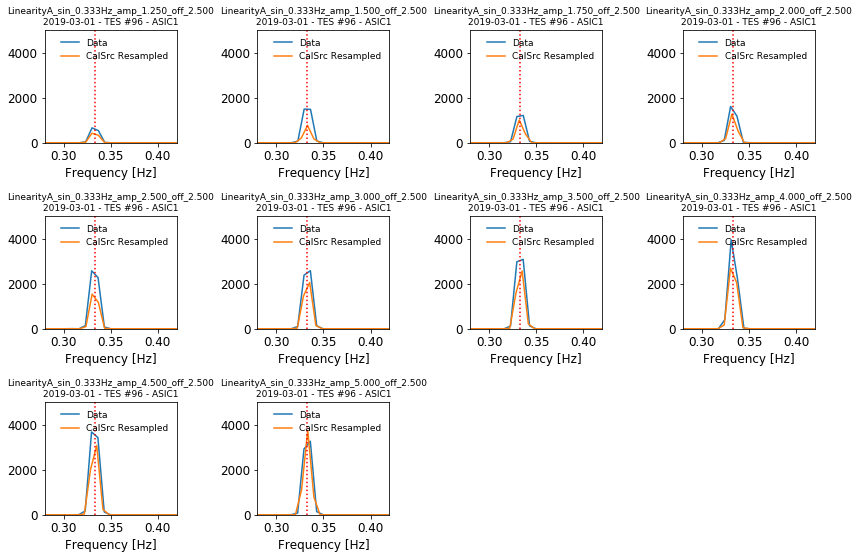

In [22]:
rc('figure',figsize=(12,10))
npl = int(np.sqrt(len(tt)))+1
fdata=0.0001
fsrc=0.0001
for ii in xrange(len(dd_src)):
    subplot(npl,npl,ii+1)
#     spectrum_src, freq_src = mlab.psd(dd_src[ii], Fs=1./np.mean(tt_src[0][1:]-tt_src[0][:-1]), 
#                                       NFFT=len(tt_src[ii]), window=mlab.window_hanning)
    spectrum, freq = mlab.psd(dd[ii], Fs=FREQ_SAMPLING, NFFT=len(tt[ii]), window=mlab.window_hanning)
    
    ## Resampling calsrc data
    newtime_src = np.arange(len(dd_src[ii]))*np.mean(tt_src[0][1:]-tt_src[0][:-1])
    newdata_src = np.interp(newtime_src, tt_src[ii], dd_src[ii])
    spectrum_src2, freq_src2 = mlab.psd(newdata_src, Fs=1./np.mean(tt_src[0][1:]-tt_src[0][:-1]), 
                                        NFFT=len(tt_src[ii]), window=mlab.window_hanning)
    
    plot(freq, f.gaussian_filter1d(spectrum,fdata)/np.mean(spectrum), label='Data')
    #plot(freq_src, f.gaussian_filter1d(spectrum_src,fsrc)/np.mean(spectrum_src), label='CalSrc')
    plot(freq_src2, f.gaussian_filter1d(spectrum_src2,fsrc)/np.mean(spectrum_src2), label='CalSrc Resampled')
    legend(fontsize=9,frameon=False)
    xlim(0.28,0.42)
    ylim(0,5000)
    xlabel('Frequency [Hz]')
    plot([modfreqs[ii],modfreqs[ii]],[0,5000],'r:')
    title(labels[ii]+'\n'+day+' - TES #{} - ASIC{}'.format(TESnum, asicnum),fontsize=9)

tight_layout()

Below is how to model the source signal (Code by D. Mennella). We first read the data file and use it as a global variable (in order not to have to read at each fit iteration which would slow down the fitting very significantly), then construct a function for the sine input modulation modulated with this efficiency law: the sinesat function. It has 6 parameters, the two first are realted to the instrument:
- The amplitude of the QUBIC measured signal in ADU of the instrument
- The offset of the QUBCI measured signal in ADU of the instrument

and the 4 others are related to the source (and kept fixed during fitting):
- the voltage amplitude of the modulation of the source
- the period modulation of the source (in sec)
- the phase (in radians) of the modualtion
- the offset in V of the modulation

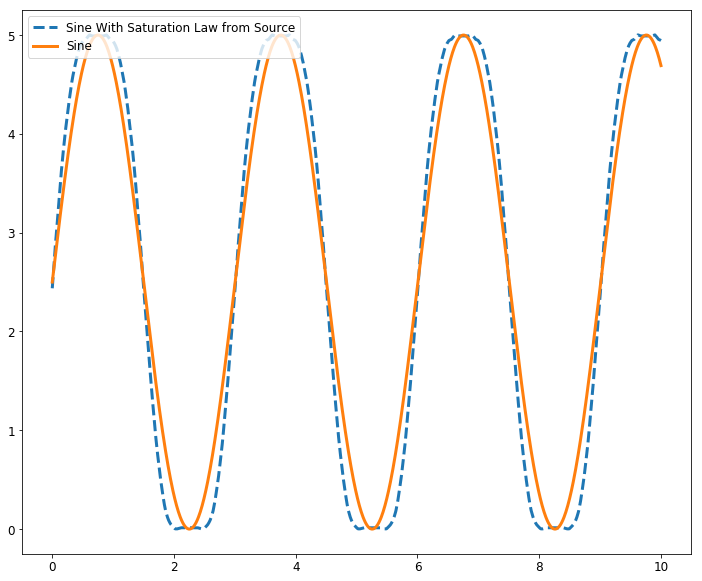

In [6]:
ttt = np.linspace(0,10,1000)
plot(ttt, ll.sinesat(ttt, [5.,0., 5., 1./0.333,0., 2.5]),'--', lw=3,label='Sine With Saturation Law from Source')
plot(ttt, ll.sine(ttt, [5., 1./0.333,0., 2.5]), lw=3,label='Sine')
legend(loc='upper left')

We now fold the data and the CalSrc over one period, then fit a sinewave on the folded data.

# NB: we reverse signs for the data here in order to have positive signal when the source is up.

In [43]:
reload(ft)
reload(ll)
nbins = 50
allfolded = np.zeros((len(tt), nbins))
allfolded_src = np.zeros((len(tt), nbins))
allresfit = np.zeros((len(tt), 4))
allerrfit = np.zeros((len(tt), 4))
allresfit_src = np.zeros((len(tt), 3))
allerrfit_src = np.zeros((len(tt), 3))
allresfit_src_model = np.zeros((len(tt), 6))
allerrfit_src_model = np.zeros((len(tt), 6))
allres = []
for ii in xrange(len(tt)):
    ##### Folding data
    ns = len(tt[ii])
    modulation_frequency = modfreqs[ii]
    folded, t, folded_nonorm, dy = ft.fold_data(tt[ii], -np.reshape(dd[ii], (1,ns)), 
                                            1./modulation_frequency, 0.01, 100., nbins, 
                                                notch=None, return_error=True, silent=True)
    allfolded[ii,:] = folded_nonorm
    ##### Fitting folded data with a sine
    guess = np.array([5000.*amps[ii], 1./modulation_frequency, 1.,0.])
    res = ft.do_minuit(t,allfolded[ii,:],dy, 
                       guess, functname=ll.sine, fixpars=[0,1,0,0],verbose=False, force_chi2_ndf=True)
    allresfit[ii,:] = res[1]
    allerrfit[ii,:] = res[2]

    ##### Folding Source data
    folded_src, tsrc, folded_nonorm_src, dy_src = ft.fold_data(tt_src[ii], np.reshape(dd_src[ii], (1,len(dd_src[ii]))), 
                                            1./modulation_frequency, 0.01, 100., nbins, 
                                                               notch=None, return_error=True, silent=True)
    allfolded_src[ii,:] = folded_nonorm_src

    ##### Fitting a possible shift in t and y to source data
    guess = np.array([600, 0.1,100])
    res = ft.do_minuit([t,allfolded_src[ii,:], 1./modulation_frequency],allfolded[ii,:],dy, 
                        guess, functname=ll.shift_src, fixpars=[0,0,0],verbose=False, force_chi2_ndf=True, nohesse=True)
    allresfit_src[ii,:] = res[1]
    allerrfit_src[ii,:] = res[2]    
    
    ##### Fitting The model source data
    guess = np.array([600, np.mean(allfolded[ii,:]),  amps[ii], 1./modfreqs[ii],np.mean(t), offsets[ii]])
    res = ft.do_minuit(t,allfolded[ii,:],dy, 
                        guess, functname=ll.sinesat, fixpars=[0,0,1,1,0,1],verbose=False, force_chi2_ndf=True, nohesse=True)
    allresfit_src_model[ii,:] = res[1]
    allerrfit_src_model[ii,:] = res[2]

Next cell is just a plot of the previous calculations. Normally one sees the saturation effect on the calsrc and the data for some of the files.

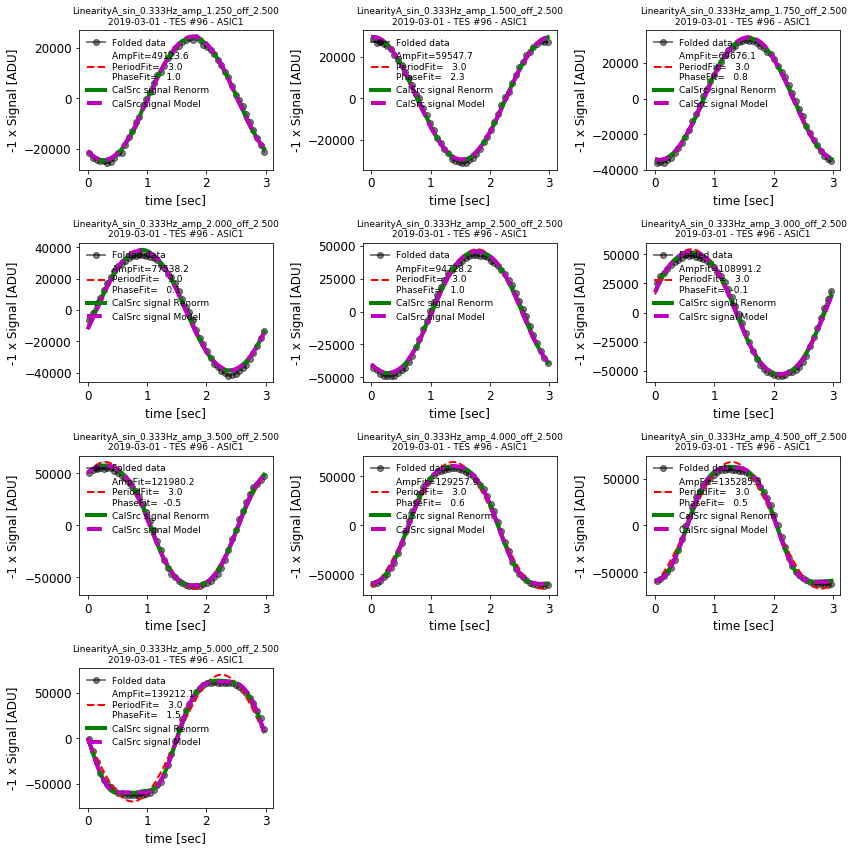

In [48]:
#### npl = int(np.sqrt(len(tt)))+1
rc('figure',figsize=(12,12))
ttt = np.linspace(0,np.max(t),1000)
for ii in xrange(len(tt)):
    subplot(4,3,ii+1)
    p=plot(t,allfolded[ii,:],'ko-', lw=2, alpha=0.5,label='Folded data')
    plot(ttt, ll.sine(ttt, allresfit[ii,:]),'r--', lw=2, 
           label='AmpFit={0:6.1f} \nPeriodFit={1:6.1f} \nPhaseFit={2:6.1f}'.format(allresfit[ii,0],
                                                                                   allresfit[ii,1],allresfit[ii,2]))
    p=plot(tsrc, ll.shift_src([tsrc,allfolded_src[ii,:], 1./modulation_frequency] , allresfit_src[ii,:]),'g-', lw=4, label='CalSrc signal Renorm')
    p=plot(ttt, ll.sinesat(ttt, allresfit_src_model[ii,:]),'m--', lw=4, label='CalSrc signal Model')
    title(labels[ii]+'\n'+day+' - TES #{} - ASIC{}'.format(TESnum, asicnum),fontsize=9)
    xlabel('time [sec]')
    ylabel('-1 x Signal [ADU]')
    legend(fontsize=9,frameon=False, loc='upper left')
tight_layout()

In fact what we want is to see the output of the TES as a function of the input power. So this is what we do in the next cell. The input power can be chosen form the input sinewave (that does not contain the intrinsic non-linearity of the source) or the calsrc data. Of course the latter is the relevant one.

Below we plot the (amplitude, phase and offset adjusted - as above) input signal as a function of the TES measured signal. There are three cases (three lines in the plot below, left columns): 
- fitted sinewave
- calibration source signal
- calibration source model

Each time we fit this data with a linear model and a logistic function model. 

In the case of the linear model one expects the slope to be constant if there is no saturation and to decrease when there is saturation. Therefore to be constant up to a certain modulation amplitude and start to decrease beyond the "non linear" limit. This is shown in the middle column. 

In the case of the logistic finction fit, we plot the width of the logistic curve (parameter pars[2]). Here again it is expected to be small in the case of no saturation and increase when entering in the saturation mode.

In [108]:
import scipy as sc
methods = ['Fitted Sinewave', 'CalSrc Signal', 'Model CalSrc Signal']
nbm = len(methods)

#### Linear fitting parameters
allres = np.zeros((nbm, 2,len(tt)))
allres_d = np.zeros((nbm, 2,len(tt)))
allerr = np.zeros((nbm, 2,len(tt)))

#### Logistic fitting parameters
allres_logistic = np.zeros((nbm, 4,len(tt)))
allerr_logistic = np.zeros((nbm, 4,len(tt)))

for im in xrange(len(methods)):
    for ii in xrange(len(tt)):
        if methods[im]=='Fitted Sinewave':
            params = allresfit[ii,:]#np.array([amps[ii]/2, 1./modfreqs[ii], allresfit[ii,2],offsets[ii]])
            input_curve = ll.sine(t, params)
        elif methods[im]=='CalSrc Signal':
            input_curve = ll.shift_src([tsrc,allfolded_src[ii,:], 1./modulation_frequency], allresfit_src[ii,:])/np.abs(allresfit_src[ii,0])
        elif methods[im] == 'Model CalSrc Signal':
            input_curve = ll.sinesat(tsrc, allresfit_src_model[ii,:])/np.abs(allresfit_src_model[ii,0])+0.5

        ### Fitting with a straight line
        res = ft.do_minuit(input_curve, allfolded[ii,:],np.zeros(len(t))+1., 
                       np.array([0.,10000.]), functname=ft.thepolynomial,verbose=False, force_chi2_ndf=True)
        allres[im, :,ii] = res[1]
        allerr[im, :,ii] = res[2]
        ### Fitting with a straight line "a la Daniele"
        res = sc.stats.linregress(input_curve, allfolded[ii,:])
        allres_d[im, :, ii] = res[0:2]
        

        ### Fitting with an efficiency curve
        if ii == 0:
            guess = np.array([np.max(allfolded[ii,:]),np.mean(input_curve),np.std(input_curve),np.min(allfolded[ii,:])])
        else:
            guess = res_logistic[1]
        res_logistic = ft.do_minuit(input_curve, allfolded[ii,:],np.zeros(len(t))+1., 
                       guess, functname=ll.logistic,verbose=False, force_chi2_ndf=True, nohesse=True)
        allres_logistic[im, :,ii] = res_logistic[1]
        allerr_logistic[im, :,ii] = res_logistic[2]



Fitted Sinewave

CalSrc Signal

Model CalSrc Signal


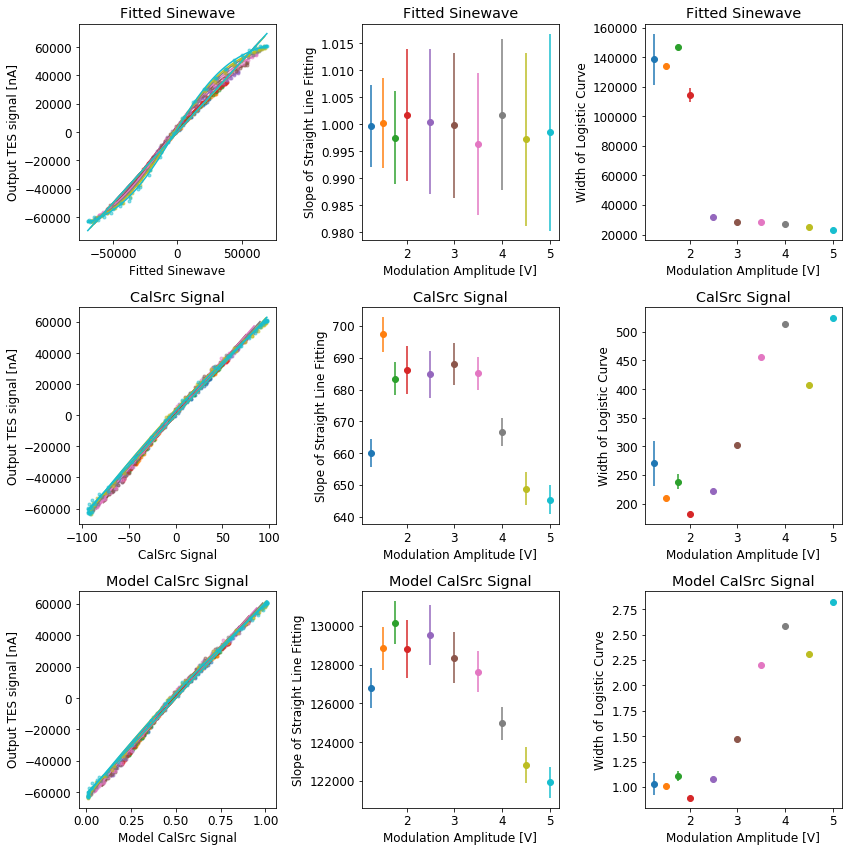

In [109]:
rc('figure',figsize=(12,12))

for im in xrange(len(methods)):
    print ''
    print methods[im]
    for ii in xrange(len(tt)):
        subplot(3,3,3*im+1)
        if methods[im]=='Fitted Sinewave':
            params = allresfit[ii,:]#np.array([amps[ii]/2, 1./modfreqs[ii], allresfit[ii,2], offsets[ii]])
            input_curve = ll.sine(t, params)
        elif methods[im]=='CalSrc Signal':
            input_curve = ll.shift_src([tsrc,allfolded_src[ii,:], 1./modulation_frequency], allresfit_src[ii,:])/np.abs(allresfit_src[ii,0])
        elif methods[im]=='Model CalSrc Signal':
            input_curve = ll.sinesat(tsrc, allresfit_src_model[ii,:])/np.abs(allresfit_src_model[ii,0])+0.5

        p=plot(input_curve, allfolded[ii,:], '.', alpha=0.5)
        xxx = np.linspace(np.min(input_curve),np.max(input_curve),100)
        plot(xxx, ft.thepolynomial(xxx, allres[im,:,ii]), color=p[0].get_color())
        plot(xxx, ll.logistic(xxx, allres_logistic[im, :,ii]), color=p[0].get_color())
        xlabel(methods[im])
        ylabel('Output TES signal [nA]')
        title(methods[im])

    
        subplot(3,3,3*im+2)
        errorbar(amps[ii], allres[im, 0,ii], yerr=allerr[im, 0,ii],fmt='o', color=p[0].get_color())
        xlabel('Modulation Amplitude [V]')
        ylabel('Slope of Straight Line Fitting')
        title(methods[im])

        subplot(3,3,3*im+3)
        amp_width = allres_logistic[im, 2,ii]
        err_amp_width = allerr_logistic[im, 2,ii]
        errorbar(amps[ii], amp_width, yerr=err_amp_width,fmt='o', color=p[0].get_color())
        xlabel('Modulation Amplitude [V]')
        ylabel('Width of Logistic Curve')
        title(methods[im])
tight_layout()

### One can conclude from this series of plot (with a single TES for now) that saturation is observed when modulating with an amplitude larger that 2.5 Volts.


Fitted Sinewave

CalSrc Signal

Model CalSrc Signal


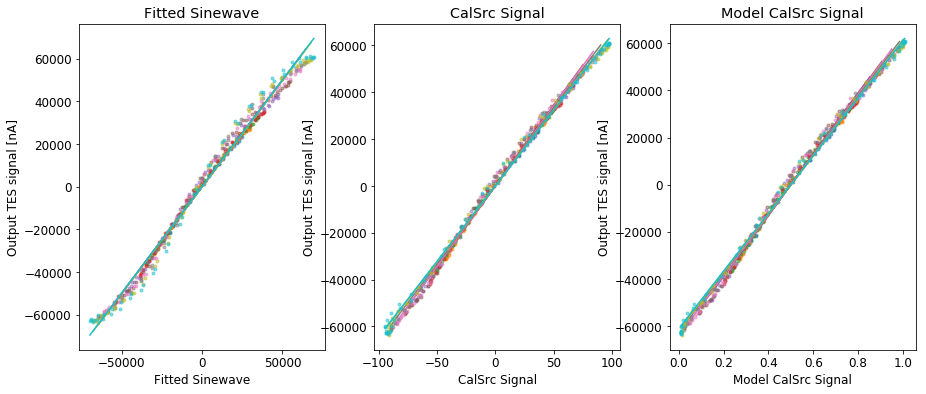

In [102]:

for im in xrange(len(methods)):
    print ''
    print methods[im]
    for ii in xrange(len(tt)):
        subplot(1,3,im+1)
        if methods[im]=='Fitted Sinewave':
            params = allresfit[ii,:]#np.array([amps[ii]/2, 1./modfreqs[ii], allresfit[ii,2], offsets[ii]])
            input_curve = ll.sine(t, params)
        elif methods[im]=='CalSrc Signal':
            input_curve = ll.shift_src([tsrc,allfolded_src[ii,:], 1./modulation_frequency], allresfit_src[ii,:])/np.abs(allresfit_src[ii,0])
        elif methods[im]=='Model CalSrc Signal':
            input_curve = ll.sinesat(tsrc, allresfit_src_model[ii,:])/np.abs(allresfit_src_model[ii,0])+0.5

        p=plot(input_curve, allfolded[ii,:], '.', alpha=0.5)
        xxx = np.linspace(np.min(input_curve),np.max(input_curve),100)
        plot(xxx, ft.thepolynomial(xxx, allres[im, :,ii]), color=p[0].get_color())
        #plot(xxx, ll.logistic(xxx, allres_logistic[im, :,ii]), color=p[0].get_color())
        xlabel(methods[im])
        ylabel('Output TES signal [nA]')
        title(methods[im])



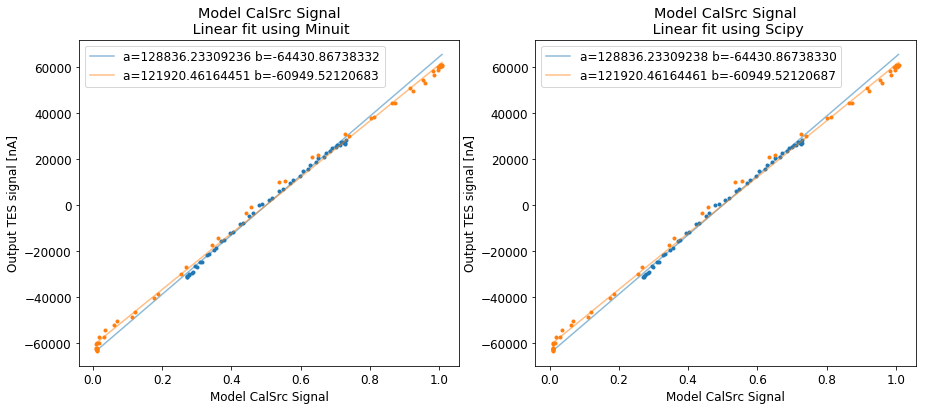

In [121]:
rc('figure',figsize=(15,6))
wok = where((amps==1.5) | (amps==5))
for ii in wok[0]:
    xtoplot = ll.sinesat(tsrc, allresfit_src_model[ii,:])/np.abs(allresfit_src_model[ii,0])+0.5
    ytoplot = allfolded[ii,:]

    subplot(1,2,1)
    p=plot(xtoplot, ytoplot, '.')
    xxx = np.linspace(np.min(input_curve),np.max(input_curve),100)
    plot(xxx, ft.thepolynomial(xxx, allres[im, :,ii]), color=p[0].get_color(), alpha=0.5, label='a={0:5.8f} b={1:5.8f}'.format(allres[im, 0,ii], allres[im, 1,ii]))
    xlabel(methods[im])
    ylabel('Output TES signal [nA]')
    title(methods[im]+'\n Linear fit using Minuit')
    legend()

    subplot(1,2,2)
    p=plot(xtoplot, ytoplot, '.')
    xxx = np.linspace(np.min(input_curve),np.max(input_curve),100)
    plot(xxx, ft.thepolynomial(xxx, allres_d[im, :,ii]), color=p[0].get_color(), alpha=0.5, label='a={0:5.8f} b={1:5.8f}'.format(allres_d[im, 0,ii], allres_d[im, 1,ii]))
    xlabel(methods[im])
    ylabel('Output TES signal [nA]')
    title(methods[im]+'\n Linear fit using Scipy')
    legend()


In [118]:
print allres[2,:,wok]
print allres_d[2,:,wok]

[[[128836.23309236 -64430.86738332]
  [121920.46164451 -60949.52120683]]]
[[[128836.23309238 -64430.8673833 ]
  [121920.46164461 -60949.52120687]]]
